In [7]:
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import grid_utils as grid_util
import grid as stimgrid

In [11]:
# load data
data_path = 'preprocessed_singlespot/201118_cell1_A.npz'
dat = np.load(data_path)
psc, I, L = dat['psc'], dat['I'], dat['L']
y_raw = psc.sum(1)

In [12]:
np.unique(I)

array([50., 70.])

In [13]:
stacked_psc, num_stims = grid_util.stack_observations_in_grid(psc, I, L)
mean_map, _, _ = grid_util.make_suff_stats(y_raw, I, L)

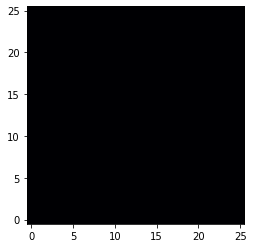

In [14]:
plt.imshow(mean_map[-1,:,:,3], origin='lower', vmin=0, vmax=15, cmap='magma')

In [15]:
plot_kwargs = {'cmap':'magma'}
fig = plt.figure(figsize=(3, 5), dpi=300, facecolor='white')

<Figure size 900x1500 with 0 Axes>

In [ ]:
grid_util.plot_multi_means(fig,
    [mean_map], np.arange(5),
    map_names=['raw', ],
    cmaps=['magma',],
    cbar_labels=['EPSQ (nC)',],
    vranges=[(0,10)],
    powers=np.unique(I))

In [ ]:
def sequential_map(vals):
    uniques = sorted(np.unique(vals))
    return {x: range(len(uniques))[i] for i,x in enumerate(uniques)}

In [ ]:
def extract_roi(ps, xs, ys, zs, psc_tensor):
    P, X, Y, Z = np.meshgrid(ps, xs, ys, zs, indexing='ij')    
    return psc_tensor[P, X, Y, Z]

In [ ]:
ps = np.arange(3)
xs = np.arange(6,25)
ys = np.arange(7,21)
zs = np.arange(5)
P, X, Y, Z = np.meshgrid(ps, xs, ys, zs, indexing='ij')

In [ ]:
psc_tensor = grid_util.make_psc_tensor(psc, I, L)
roi_tensor = extract_roi(ps, xs, ys, zs, psc_tensor)
roi_mean_map = np.nanmean(np.nansum(roi_tensor, axis=-1), axis=-1)

In [ ]:
plot_kwargs = {'cmap':'magma'}
fig = plt.figure(figsize=(3, 5), dpi=300, facecolor='white')

In [ ]:
grid_util.plot_multi_means(fig,
    [roi_mean_map], np.arange(5),
    map_names=['raw', ],
    cmaps=['magma',],
    vranges=[(-1.0, 10.0)])

In [ ]:
roi_tensor.shape

In [ ]:
from tensorly.decomposition import parafac, non_negative_parafac
import tensorly as tl

In [ ]:
def estimate_photocurrents(roi_tensor, separate_by_powers=True, rank=1, l2_reg=0.0):
    npowers, nx, ny, nz, ntrials, ntimesteps = roi_tensor.shape


    subtracted = np.copy(roi_tensor)
    full_est = np.copy(roi_tensor)
    
    for z_idx in range(nz):

        for power_idx in range(npowers):

            # extract current tensor we're working with. Different powers
            # can have different numbers of trials, which are marked by np.nan
            try:
                ntrials_curr = np.where(np.isnan(roi_tensor[power_idx, 0, 0, 0, :, 0]))[0][0]
            except IndexError:
                ntrials_curr = ntrials

            # This forms an index to extract a particular (power, trials, plane) combination
            _slice = np.s_[power_idx, :, :, z_idx, 0:ntrials_curr, :]
            
            tensor_curr = roi_tensor[_slice].reshape(-1, ntrials_curr, ntimesteps)

            # form rank1 approx and subtract
            cptensor = non_negative_parafac(np.maximum(tensor_curr, 0),
                               rank=rank,)

            est = tl.cp_to_tensor(cptensor).reshape(nx, ny, ntrials_curr, ntimesteps)
            subtracted[_slice] = roi_tensor[_slice] - est
            full_est[_slice] = est


    return full_est, subtracted

In [ ]:
est, subtracted = estimate_photocurrents(roi_tensor,
                                         separate_by_powers=True, l2_reg=1, rank=1)

In [ ]:
# place ROI back into grid
psc_tensor_corrected = np.copy(psc_tensor)
psc_tensor_corrected[P, X, Y, Z] = subtracted

In [ ]:
mean_map_subtracted = np.nanmean(np.nansum(psc_tensor_corrected, axis=-1), axis=-1)

In [ ]:
fig = plt.figure(figsize=(8, 5), dpi=300, facecolor='white')

In [ ]:
stacked = np.concatenate((mean_map, mean_map_subtracted), axis=3)
grid_util.plot_multi_means(fig,
    [mean_map, mean_map_subtracted], np.arange(5),
    map_names=['raw', 'subtracted'],
    cmaps=['magma', 'magma'],
    cbar_labels=['EPSQ (nC)', 'EPSQ (nC)'],
    vranges=[(-1,15), (-1,15)],
    powers=np.unique(I),
    )

In [ ]:
est.shape

In [ ]:
est.shape

In [ ]:
num_trials

In [ ]:
npowers, _, _, _, num_trials, timesteps = roi_tensor.shape

In [ ]:
npowers, _, _, _, num_trials, timesteps = roi_tensor.shape
npowers

In [ ]:
powers = np.unique(I)
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=3,
                    figsize=(15,1 * num_plots), dpi=300,
                    sharey=True, sharex=True, facecolor='white')

In [ ]:
for pidx in [0,1,2]:

    est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
    raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
    sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

    for i in range(num_plots):
        trace_idx = order[i]

        axs[i,pidx].plot(raw_traces[trace_idx].T, color=colors[r], alpha=0.9,linewidth=0.5)
        axs[i,pidx].plot(est_traces[trace_idx].T, color=colors[r], alpha=0.9,linewidth=0.5)
        axs[i,pidx].plot(sub_traces[trace_idx].T, color=colors[r], alpha=0.9,linewidth=0.5)

        # plot initiation time of stim
        for j in range(9):
            plt.sca(axs[i,j])
            plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

    axs[0,pidx].set_title('raw \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('est \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=-1))
powers = np.unique(I)
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=3,
                    figsize=(15,1 * num_plots), dpi=300,
                    sharey=True, sharex=True, facecolor='white')

In [ ]:
for pidx in [0,1,2]:

    est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
    raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
    sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

    for i in range(num_plots):
        trace_idx = order[i]

        axs[i,pidx].plot(raw_traces[trace_idx].T, color=colors[r], alpha=0.9,linewidth=0.5)
        axs[i,pidx].plot(est_traces[trace_idx].T, color=colors[r], alpha=0.9,linewidth=0.5)
        axs[i,pidx].plot(sub_traces[trace_idx].T, color=colors[r], alpha=0.9,linewidth=0.5)

        # plot initiation time of stim
        for j in range(9):
            plt.sca(axs[i,j])
            plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

    axs[0,pidx].set_title('raw \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('est \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=-1))
powers = np.unique(I)
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=3,
                    figsize=(15,1 * num_plots), dpi=300,
                    sharey=True, sharex=True, facecolor='white')

In [ ]:
for pidx in [0,1,2]:

    est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
    raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
    sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

    for i in range(num_plots):
        trace_idx = order[i]

        axs[i,pidx].plot(raw_traces[trace_idx].T, alpha=0.9,linewidth=0.5)
        axs[i,pidx].plot(est_traces[trace_idx].T, alpha=0.9,linewidth=0.5)
        axs[i,pidx].plot(sub_traces[trace_idx].T, alpha=0.9,linewidth=0.5)

        # plot initiation time of stim
        for j in range(9):
            plt.sca(axs[i,j])
            plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

    axs[0,pidx].set_title('raw \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('est \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
raw_traces.shape

In [ ]:
trace_idx

In [ ]:
order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=(-1,-2)))
powers = np.unique(I)
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=3,
                    figsize=(15,1 * num_plots), dpi=300,
                    sharey=True, sharex=True, facecolor='white')

In [ ]:
for pidx in [0,1,2]:

    est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
    raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
    sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

    for i in range(num_plots):
        trace_idx = order[i]

        axs[i,pidx].plot(raw_traces[trace_idx].T, alpha=0.9,linewidth=0.5)
        axs[i,pidx].plot(est_traces[trace_idx].T, alpha=0.9,linewidth=0.5)
        axs[i,pidx].plot(sub_traces[trace_idx].T, alpha=0.9,linewidth=0.5)

        # plot initiation time of stim
        for j in range(9):
            plt.sca(axs[i,j])
            plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

    axs[0,pidx].set_title('raw \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('est \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=(-1,-2)))
powers = np.unique(I)
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=3,
                    figsize=(15,1 * num_plots), dpi=300,
                    sharey=True, sharex=True, facecolor='white')

In [ ]:
for pidx in [0,1,2]:

    est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
    raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
    sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

    for i in range(num_plots):
        trace_idx = order[i]

        axs[i,pidx].plot(raw_traces[trace_idx].T, alpha=0.9,linewidth=0.5)
        axs[i,pidx].plot(est_traces[trace_idx].T, alpha=0.9,linewidth=0.5)
        axs[i,pidx].plot(sub_traces[trace_idx].T, alpha=0.9,linewidth=0.5)

        # plot initiation time of stim
        for j in range(3):
            plt.sca(axs[i,j])
            plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

    axs[0,pidx].set_title('raw \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('est \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=(-1,-2)))
powers = np.unique(I)
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=3,
                    figsize=(15,1 * num_plots), dpi=300,
                    sharey=True, sharex=True, facecolor='white')

In [ ]:
for pidx in [0,1,2]:

    est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
    raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
    sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

    for i in range(num_plots):
        trace_idx = order[i]

        axs[i,pidx].plot(raw_traces[trace_idx].T, alpha=0.9,linewidth=0.9)
        axs[i,pidx].plot(est_traces[trace_idx].T, alpha=0.9,linewidth=0.9)
        axs[i,pidx].plot(sub_traces[trace_idx].T, alpha=0.9,linewidth=0.9)

        # plot initiation time of stim
        for j in range(3):
            plt.sca(axs[i,j])
            plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

    axs[0,pidx].set_title('raw \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('est \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=(-1,-2)))[::-1]
powers = np.unique(I)
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=3,
                    figsize=(15,1 * num_plots), dpi=300,
                    sharey=True, sharex=True, facecolor='white')

In [ ]:
for pidx in [0,1,2]:

    est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
    raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
    sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

    for i in range(num_plots):
        trace_idx = order[i]

        axs[i,pidx].plot(raw_traces[trace_idx].T, alpha=0.9)
        axs[i,pidx].plot(est_traces[trace_idx].T, alpha=0.9)
        axs[i,pidx].plot(sub_traces[trace_idx].T, alpha=0.9)

        # plot initiation time of stim
        for j in range(3):
            plt.sca(axs[i,j])
            plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

    axs[0,pidx].set_title('raw \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('est \n %.1f' % powers[pidx])
    axs[0,pidx].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=(-1,-2)))[::-1]
powers = np.unique(I)
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=9,
                    figsize=(15,1 * num_plots), dpi=300,
                    sharey=True, sharex=True, facecolor='white')

In [ ]:
for pidx in [0,1,2]:

    est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
    raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
    sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

    for i in range(num_plots):
        trace_idx = order[i]

        axs[i,pidx].plot(raw_traces[trace_idx].T, alpha=0.9)
        axs[i,pidx + 1].plot(est_traces[trace_idx].T, alpha=0.9)
        axs[i,pidx + 2].plot(sub_traces[trace_idx].T, alpha=0.9)

        # plot initiation time of stim
        for j in range(3):
            plt.sca(axs[i,j])
            plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

    axs[0,pidx].set_title('raw \n %.1f' % powers[pidx])
    axs[0,pidx + 1].set_title('est \n %.1f' % powers[pidx])
    axs[0,pidx + 2].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=(-1,-2)))[::-1]
powers = np.unique(I)
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=9,
                    figsize=(15,1 * num_plots), dpi=300,
                    sharey=True, sharex=True, facecolor='white')

In [ ]:
for pidx, j in zip([0,1,2], [0,3,6]):

    est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
    raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
    sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

    for i in range(num_plots):
        trace_idx = order[i]

        axs[i,j].plot(raw_traces[trace_idx].T, alpha=0.9)
        axs[i,j + 1].plot(est_traces[trace_idx].T, alpha=0.9)
        axs[i,j + 2].plot(sub_traces[trace_idx].T, alpha=0.9)

        # plot initiation time of stim
        for j in range(3):
            plt.sca(axs[i,j])
            plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

    axs[0,pidx].set_title('raw \n %.1f' % powers[pidx])
    axs[0,pidx + 1].set_title('est \n %.1f' % powers[pidx])
    axs[0,pidx + 2].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=(-1,-2)))[::-1]
powers = np.unique(I)
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=9,
                    figsize=(15,1 * num_plots), dpi=300,
                    sharey=True, sharex=True, facecolor='white')

In [ ]:
for pidx, j in zip([0,1,2], [0,3,6]):

    est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
    raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
    sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

    for i in range(num_plots):
        trace_idx = order[i]

        axs[i,j].plot(raw_traces[trace_idx].T, alpha=0.9)
        axs[i,j + 1].plot(est_traces[trace_idx].T, alpha=0.9)
        axs[i,j + 2].plot(sub_traces[trace_idx].T, alpha=0.9)

        # plot initiation time of stim
        for j in range(3):
            plt.sca(axs[i,j])
            plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

    axs[0,j].set_title('raw \n %.1f' % powers[pidx])
    axs[0,j + 1].set_title('est \n %.1f' % powers[pidx])
    axs[0,j + 2].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=(-1,-2)))[::-1]
powers = np.unique(I)
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=9,
                    figsize=(15,1 * num_plots), dpi=300,
                    sharey=True, sharex=True, facecolor='white')

In [ ]:
for pidx, j in zip([0,1,2], [0,3,6]):

    est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
    raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
    sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

    for i in range(num_plots):
        trace_idx = order[i]

        axs[i,j].plot(raw_traces[trace_idx].T, alpha=0.9)
        axs[i,j + 1].plot(est_traces[trace_idx].T, alpha=0.9)
        axs[i,j + 2].plot(sub_traces[trace_idx].T, alpha=0.9)

        # plot initiation time of stim
        for j in range(3):
            plt.sca(axs[i,j])
            plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

    print(j)
    axs[0,j].set_title('raw \n %.1f' % powers[pidx])
    axs[0,j + 1].set_title('est \n %.1f' % powers[pidx])
    axs[0,j + 2].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=(-1,-2)))[::-1]
powers = np.unique(I)
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=9,
                    figsize=(15,1 * num_plots), dpi=300,
                    sharey=True, sharex=True, facecolor='white')

In [ ]:
for pidx, j in zip([0,1,2], [0,3,6]):

    est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
    raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
    sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

    for i in range(num_plots):
        trace_idx = order[i]

        axs[i,j].plot(raw_traces[trace_idx].T, alpha=0.9)
        axs[i,j + 1].plot(est_traces[trace_idx].T, alpha=0.9)
        axs[i,j + 2].plot(sub_traces[trace_idx].T, alpha=0.9)

        # plot initiation time of stim
        for k in range(9):
            plt.sca(axs[i,k])
            plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

    print(j)
    axs[0,j].set_title('raw \n %.1f' % powers[pidx])
    axs[0,j + 1].set_title('est \n %.1f' % powers[pidx])
    axs[0,j + 2].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
def plot_photocurrent_traces(roi_tensor, est, subtracted):
    npowers, _, _, _, num_trials, timesteps = roi_tensor.shape
    order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=(-1,-2)))[::-1]
    powers = np.unique(I)
    num_plots = 20
    fig, axs = plt.subplots(nrows=num_plots, ncols=9,
                        figsize=(15,1 * num_plots), dpi=300,
                        sharey=True, sharex=True, facecolor='white')


    for pidx, j in zip([0,1,2], [0,3,6]):

        est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
        raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
        sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

        for i in range(num_plots):
            trace_idx = order[i]

            axs[i,j].plot(raw_traces[trace_idx].T, alpha=0.9)
            axs[i,j + 1].plot(est_traces[trace_idx].T, alpha=0.9)
            axs[i,j + 2].plot(sub_traces[trace_idx].T, alpha=0.9)

            # plot initiation time of stim
            for k in range(9):
                plt.sca(axs[i,k])
                plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

        print(j)
        axs[0,j].set_title('raw \n %.1f' % powers[pidx])
        axs[0,j + 1].set_title('est \n %.1f' % powers[pidx])
        axs[0,j + 2].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
plot_photocurrent_traces(roi_tensor, est, subtracted)

In [ ]:
plot_photocurrent_traces(roi_tensor[:, :, :, -1, ...], est[:, :, :, -1, ...], subtracted[:, :, :, -1, ...])

In [ ]:
plot_photocurrent_traces(roi_tensor[:, :, :, 0:2, ...], est[:, :, :, 0:2, ...], subtracted[:, :, :, 0:2, ...])

In [ ]:
def plot_photocurrent_traces(roi_tensor, est, subtracted):
    npowers, _, _, _, num_trials, timesteps = roi_tensor.shape
    order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=(-1,-2)))[::-1]
    powers = np.unique(I)
    num_plots = 50
    fig, axs = plt.subplots(nrows=num_plots, ncols=9,
                        figsize=(15,1 * num_plots), dpi=300,
                        sharey=True, sharex=True, facecolor='white')


    for pidx, j in zip([0,1,2], [0,3,6]):

        est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
        raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
        sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

        for i in range(num_plots):
            trace_idx = order[i]

            axs[i,j].plot(raw_traces[trace_idx].T, alpha=0.9)
            axs[i,j + 1].plot(est_traces[trace_idx].T, alpha=0.9)
            axs[i,j + 2].plot(sub_traces[trace_idx].T, alpha=0.9)

            # plot initiation time of stim
            for k in range(9):
                plt.sca(axs[i,k])
                plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

        print(j)
        axs[0,j].set_title('raw \n %.1f' % powers[pidx])
        axs[0,j + 1].set_title('est \n %.1f' % powers[pidx])
        axs[0,j + 2].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
plot_photocurrent_traces(roi_tensor[:, :, :, 0:2, ...], est[:, :, :, 0:2, ...], subtracted[:, :, :, 0:2, ...])

In [ ]:
def plot_photocurrent_traces(roi_tensor, est, subtracted):
    npowers, _, _, _, num_trials, timesteps = roi_tensor.shape
    order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=(-1,-2)))
    powers = np.unique(I)
    num_plots = 50
    fig, axs = plt.subplots(nrows=num_plots, ncols=9,
                        figsize=(15,1 * num_plots), dpi=300,
                        sharey=True, sharex=True, facecolor='white')


    for pidx, j in zip([0,1,2], [0,3,6]):

        est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
        raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
        sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

        for i in range(num_plots):
            trace_idx = order[i]

            axs[i,j].plot(raw_traces[trace_idx].T, alpha=0.9)
            axs[i,j + 1].plot(est_traces[trace_idx].T, alpha=0.9)
            axs[i,j + 2].plot(sub_traces[trace_idx].T, alpha=0.9)

            # plot initiation time of stim
            for k in range(9):
                plt.sca(axs[i,k])
                plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

        print(j)
        axs[0,j].set_title('raw \n %.1f' % powers[pidx])
        axs[0,j + 1].set_title('est \n %.1f' % powers[pidx])
        axs[0,j + 2].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
plot_photocurrent_traces(roi_tensor[:, :, :, 0:2, ...], est[:, :, :, 0:2, ...], subtracted[:, :, :, 0:2, ...])

In [ ]:
def plot_photocurrent_traces(roi_tensor, est, subtracted):
    npowers, nxs, nys, nzs, num_trials, timesteps = roi_tensor.shape
#     order = np.argsort(np.nansum(roi_tensor[-1,...].reshape(-1, num_trials, timesteps), axis=(-1,-2)))

    powers = np.unique(I)
    num_plots = 50
    
    order = np.random.choice(np.arange(nxs * nys * nzs), size=num_plots, replace=False)
    
    fig, axs = plt.subplots(nrows=num_plots, ncols=9,
                        figsize=(15,1 * num_plots), dpi=300,
                        sharey=True, sharex=True, facecolor='white')


    for pidx, j in zip([0,1,2], [0,3,6]):

        est_traces = est[pidx,...].reshape(-1, num_trials, timesteps)
        raw_traces = roi_tensor[pidx,...].reshape(-1, num_trials, timesteps)
        sub_traces = subtracted[pidx,...].reshape(-1, num_trials, timesteps)

        for i in range(num_plots):
            trace_idx = order[i]

            axs[i,j].plot(raw_traces[trace_idx].T, alpha=0.9)
            axs[i,j + 1].plot(est_traces[trace_idx].T, alpha=0.9)
            axs[i,j + 2].plot(sub_traces[trace_idx].T, alpha=0.9)

            # plot initiation time of stim
            for k in range(9):
                plt.sca(axs[i,k])
                plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)

        print(j)
        axs[0,j].set_title('raw \n %.1f' % powers[pidx])
        axs[0,j + 1].set_title('est \n %.1f' % powers[pidx])
        axs[0,j + 2].set_title('subtracted \n %.1f' % powers[pidx])

In [ ]:
plot_photocurrent_traces(roi_tensor[:, :, :, 0:2, ...], est[:, :, :, 0:2, ...], subtracted[:, :, :, 0:2, ...])

In [ ]:
ps = np.arange(3)
xs = np.arange(6,25)
ys = np.arange(3,21)
zs = np.arange(5)
P, X, Y, Z = np.meshgrid(ps, xs, ys, zs, indexing='ij')

In [ ]:
psc_tensor = grid_util.make_psc_tensor(psc, I, L)
roi_tensor = extract_roi(ps, xs, ys, zs, psc_tensor)
roi_mean_map = np.nanmean(np.nansum(roi_tensor, axis=-1), axis=-1)

In [ ]:
plot_kwargs = {'cmap':'magma'}
fig = plt.figure(figsize=(3, 5), dpi=300, facecolor='white')

In [ ]:
grid_util.plot_multi_means(fig,
    [roi_mean_map], np.arange(5),
    map_names=['raw', ],
    cmaps=['magma',],
    vranges=[(-1.0, 10.0)])

In [ ]:
roi_tensor.shape

In [ ]:
from tensorly.decomposition import parafac, non_negative_parafac
import tensorly as tl

In [ ]:
def estimate_photocurrents(roi_tensor, separate_by_powers=True, rank=1, l2_reg=0.0):
    npowers, nx, ny, nz, ntrials, ntimesteps = roi_tensor.shape


    subtracted = np.copy(roi_tensor)
    full_est = np.copy(roi_tensor)
    
    for z_idx in range(nz):

        for power_idx in range(npowers):

            # extract current tensor we're working with. Different powers
            # can have different numbers of trials, which are marked by np.nan
            try:
                ntrials_curr = np.where(np.isnan(roi_tensor[power_idx, 0, 0, 0, :, 0]))[0][0]
            except IndexError:
                ntrials_curr = ntrials

            # This forms an index to extract a particular (power, trials, plane) combination
            _slice = np.s_[power_idx, :, :, z_idx, 0:ntrials_curr, :]
            
            tensor_curr = roi_tensor[_slice].reshape(-1, ntrials_curr, ntimesteps)

            # form rank1 approx and subtract
            cptensor = non_negative_parafac(np.maximum(tensor_curr, 0),
                               rank=rank,)

            est = tl.cp_to_tensor(cptensor).reshape(nx, ny, ntrials_curr, ntimesteps)
            subtracted[_slice] = roi_tensor[_slice] - est
            full_est[_slice] = est


    return full_est, subtracted


In [ ]:
est, subtracted = estimate_photocurrents(roi_tensor,
                                         separate_by_powers=True, l2_reg=1, rank=1)

In [ ]:
# place ROI back into grid
psc_tensor_corrected = np.copy(psc_tensor)
psc_tensor_corrected[P, X, Y, Z] = subtracted

In [ ]:
mean_map_subtracted = np.nanmean(np.nansum(psc_tensor_corrected, axis=-1), axis=-1)

In [ ]:
fig = plt.figure(figsize=(8, 5), dpi=300, facecolor='white')

In [ ]:
stacked = np.concatenate((mean_map, mean_map_subtracted), axis=3)
grid_util.plot_multi_means(fig,
    [mean_map, mean_map_subtracted], np.arange(5),
    map_names=['raw', 'subtracted'],
    cmaps=['magma', 'magma'],
    cbar_labels=['EPSQ (nC)', 'EPSQ (nC)'],
    vranges=[(-1,15), (-1,15)],
    powers=np.unique(I),
    )